In [1]:
from keras.layers import *
from keras.models import Model
from keras import layers
from keras.layers.merge import concatenate
import sys
sys.path.insert(1, '../image_segmentation_keras')
from keras_segmentation.models.config import IMAGE_ORDERING

from keras_segmentation.models.model_utils import get_segmentation_model
from glob import glob


Using TensorFlow backend.


In [2]:
channels = 3
input_height=256 #416
input_width=256 #608

In [3]:
def unet_conv_block(inputs, filters, pool=True, batch_norm_first=True):
    if batch_norm_first == True:
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        x = Conv2D(filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    elif batch_norm_first == False:
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

        x = Conv2D(filters, 3, padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)

    if pool == True:
        p = MaxPooling2D((2, 2))(x)
        return [x, p]
    else:
        return x

In [4]:
def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels
    
    print("f5",f5.shape)

    o = f5
    
    """ Bridge """
    o = unet_conv_block(o, 2048, pool=False)
    
    o = (UpSampling2D((2, 2), data_format=IMAGE_ORDERING))(o)
    o = (concatenate([o, f4], axis=3))
    o = unet_conv_block(o, 1024, pool=False)
    
    o = UpSampling2D((2, 2), interpolation="bilinear")(o)
    o = (concatenate([o, f3], axis=3))
    o = unet_conv_block(o, 512, pool=False)
    

    o = UpSampling2D((2, 2), interpolation="bilinear")(o)
    o = (concatenate([o, f2], axis=3))
    o = unet_conv_block(o, 256, pool=False)


    o = UpSampling2D((2, 2), interpolation="bilinear")(o)
    o = (concatenate([o, f1], axis=3))
    o = unet_conv_block(o, 64, pool=False)
    
    o = UpSampling2D((2, 2), interpolation="bilinear")(o)
    o = Conv2D(n_classes, (1, 1), padding='same',
               data_format=IMAGE_ORDERING)(o)
    
    model = get_segmentation_model(img_input, o)

    return model

In [5]:
if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING,
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)
#     print(shortcut.shape)
    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height,  input_width,
                        
                         include_top=True, 
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000):
    print(input_height)
    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING,
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    return img_input, [f1, f2, f3, f4, f5]

In [6]:
def resnet50_unet(n_classes, input_height=512, input_width=512,
                  encoder_level=3):

    model = _unet(n_classes, get_resnet50_encoder,
                  input_height=input_height, input_width=input_width)
    model.model_name = "resnet50_unet"
    return model

In [7]:
model = resnet50_unet(n_classes=3 ,  input_height=256, input_width=256  )


256
f5 (None, 8, 8, 2048)


In [8]:
model.load_weights('/Users/mavaylon/Research/pet_weights/RESNET50_VANILLA_PET/pet_class_crf.h5')

In [9]:
import glob

img_names = sorted(glob.glob("/Users/mavaylon/Research/pet_predictions/img/*.png"))

for name in img_names:
    out_name = "/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/" + name.split('/')[-1]
    print(out_name)
    out = model.predict_segmentation(inp=name, out_fname=out_name)

/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/1Russian_Blue_114.png
/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/213leonberger_197.png
/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/244samoyed_39.png
/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/270Persian_44.png
/Users/mavaylon/Research/pet_predictions/unet_vanilla_pred/271Egyptian_Mau_143.png


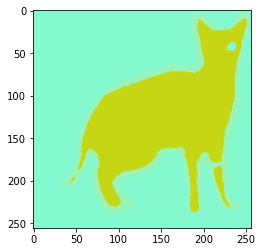

In [10]:
import cv2
import matplotlib.pyplot as plt
img=cv2.imread('/Users/mavaylon/Research/pet_predictions/unet_crf_pred/271Egyptian_Mau_143.png')
plt.imshow(img)

In [8]:
model.train(
    train_images =  "/home/maavaylon/Data1/train/img/",
    train_annotations = "/home/maavaylon/Data1/train/ann/",
    epochs=20,
    steps_per_epoch=len(glob("/home/maavaylon/Data1/train/img/*")),
    batch_size=1,
    validate=True,
    val_images="/home/maavaylon/Data1/test/img/",
    val_annotations="/home/maavaylon/Data1/test/ann/",
    val_batch_size=1,
    val_steps_per_epoch=len(glob("/home/maavaylon/Data1/test/img/*"))
)

ValueError: Could not interpret optimizer identifier: <function dice_coef_loss at 0x7fa248e49d40>